In [9]:
# you can call a function "on device"
import numpy as np
import cupy as cp
from cupyx import jit

@jit.rawkernel(device=True)
def do_a_thing(x, y):
    return (y, x)
    
@jit.rawkernel()
def do_more_things(x, y, size):
    tid = jit.blockIdx.x * jit.blockDim.x + jit.threadIdx.x
    ntid = jit.gridDim.x * jit.blockDim.x
    for i in range(tid, size, ntid):
        (x[i], y[i]) = do_a_thing(x[i], y[i])

size = 10
x = cp.random.random(size, dtype=np.float32)
y = cp.random.random(size, dtype=np.float32)

print(x)
print(y)

do_more_things((128,),(1024,),(x, y, size))

print(x)
print(y)


[0.73879254 0.36430386 0.5560938  0.13465711 0.49230078 0.8651738
 0.01775549 0.39530468 0.26143515 0.01097945]
[0.96701926 0.31582886 0.45942357 0.02675973 0.44531643 0.38146228
 0.26420838 0.38977566 0.22158593 0.36414465]
[0.96701926 0.31582886 0.45942357 0.02675973 0.44531643 0.38146228
 0.26420838 0.38977566 0.22158593 0.36414465]
[0.73879254 0.36430386 0.5560938  0.13465711 0.49230078 0.8651738
 0.01775549 0.39530468 0.26143515 0.01097945]


In [26]:
# python float scalar type doesn't work, use numpy type
import numpy as np
import cupy as cp
from cupyx import jit

@jit.rawkernel()
def scalar_multiply(a, m, size):
    tid = jit.blockIdx.x * jit.blockDim.x + jit.threadIdx.x
    ntid = jit.gridDim.x * jit.blockDim.x
    for i in range(tid, size, ntid):
        a[i] = a[i] * m

size = 5
a = cp.random.random(size, dtype=np.float32)

print(a)
scalar_multiply((128,),(1024,),(a, np.float32(5.0), size))
print(a)
scalar_multiply((128,),(1024,),(a, 5.0, size))
print(a)

[0.17959814 0.42873758 0.77541053 0.8213136  0.8284943 ]
[0.8979907 2.143688  3.8770528 4.1065683 4.1424713]
[0. 0. 0. 0. 0.]


In [117]:
%%time
x = cp.random.random(10000000, dtype=np.float32) * 2

CPU times: user 153 µs, sys: 87 µs, total: 240 µs
Wall time: 176 µs


In [102]:
%%time
y = cp.random.uniform(0, 2, 10000000, dtype=np.float32)

CPU times: user 236 µs, sys: 0 ns, total: 236 µs
Wall time: 181 µs


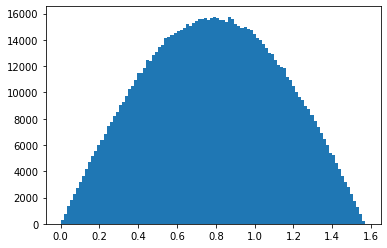

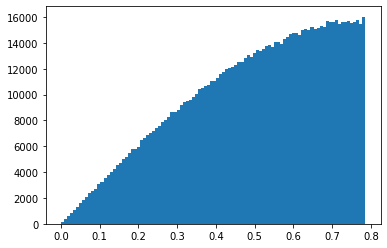

In [11]:
# i'm losing my mind
import numpy as np
import matplotlib.pyplot as plt

size = 1000000
x = np.arccos(2 * np.random.random(size) - 1) / 2
y = np.arccos(np.random.uniform(-1, 1, size))/2
plt.hist(x, bins=100);
plt.show()
plt.hist(y, bins=100);

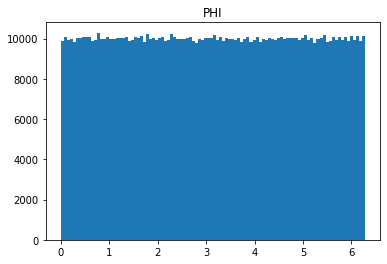

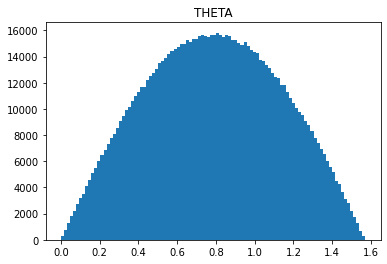

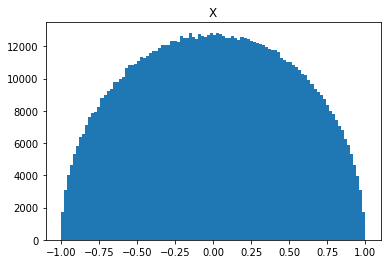

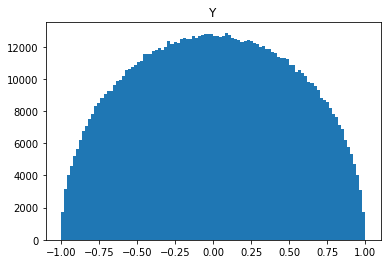

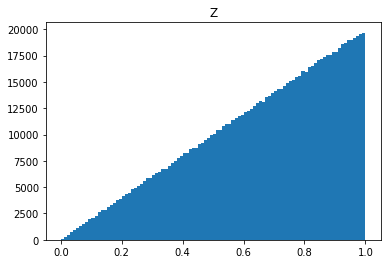

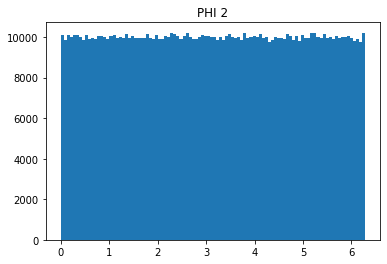

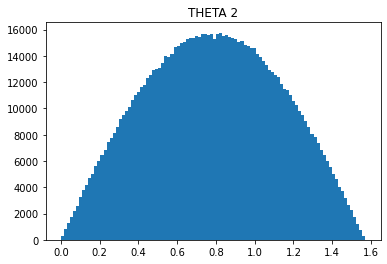

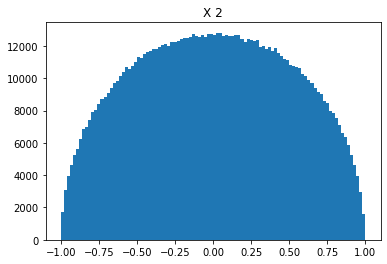

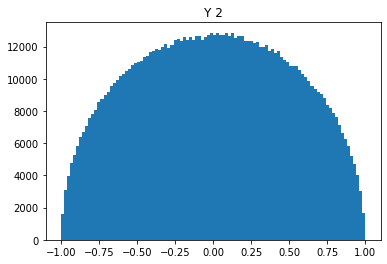

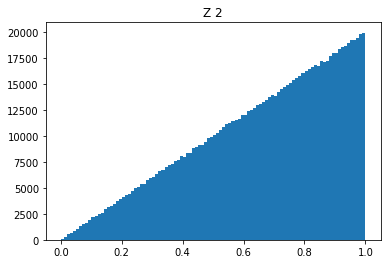

In [24]:
# in-place
import cupy as cp
import matplotlib.pyplot as plt
import numpy as np
from typing import Tuple
from cupyx import jit

@jit.rawkernel()
def spherical_to_cartesian_raw(theta_z, phi_x, y, size) -> None:
    """in-place reuses the inputs."""
    tid = jit.blockIdx.x * jit.blockDim.x + jit.threadIdx.x
    ntid = jit.gridDim.x * jit.blockDim.x
    for i in range(tid, size, ntid):
        y[i] = cp.sin(theta_z[i]) * cp.sin(phi_x[i])
        phi_x[i] = cp.sin(theta_z[i]) * cp.cos(phi_x[i])
        theta_z[i] = cp.cos(theta_z[i])
        
def spherical_to_cartesian(theta: cp.ndarray, phi: cp.ndarray) -> Tuple[cp.ndarray, cp.ndarray, cp.ndarray]:
    x = cp.sin(theta) * cp.cos(phi)
    y = cp.sin(theta) * cp.sin(phi)
    z = cp.cos(theta)
    return (x,y,z)

size = 1000000
# lambertian
phi_x = cp.random.uniform(0, 2 * np.pi, size, dtype=np.float32)
y = cp.empty(size, dtype=np.float32)
theta_z = cp.arccos(cp.random.uniform(-1, 1, size, dtype=np.float32)) / 2

plt.title('PHI')
plt.hist(phi_x.get(), bins=100)
plt.show()

plt.title('THETA')
plt.hist(theta_z.get(), bins=100)
plt.show()

# this way makes zero extra temporary columns
spherical_to_cartesian_raw((128,),(1024,),(theta_z, phi_x, y, size))

plt.title('X')
plt.hist(phi_x.get(), bins=100)
plt.show()

plt.title("Y")
plt.hist(y.get(), bins=100)
plt.show()

plt.title("Z")
plt.hist(theta_z.get(), bins=100)
plt.show()

# the other way

phi = cp.random.uniform(0, 2 * np.pi, size, dtype=np.float32)
theta = cp.arccos(cp.random.uniform(-1, 1, size, dtype=np.float32)) / 2

plt.title('PHI 2')
plt.hist(phi.get(), bins=100)
plt.show()

plt.title('THETA 2')
plt.hist(theta.get(), bins=100)
plt.show()

# this way makes two extra temporary columns
(x,y,z) = spherical_to_cartesian(theta, phi)

plt.title('X 2')
plt.hist(x.get(), bins=100)
plt.show()

plt.title("Y 2")
plt.hist(y.get(), bins=100)
plt.show()

plt.title("Z 2")
plt.hist(z.get(), bins=100)
plt.show()


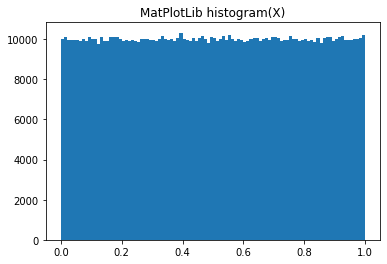

<class 'cupy.ndarray'>
<class 'cupy._core.fusion._FusionVarArray'>
<_FusionVar float32 1-dim array>


TypeError: iteration over a 0-d array

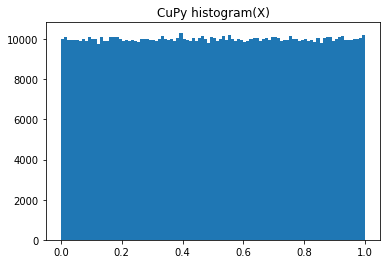

In [48]:
# calculate histograms
import cupy as cp
import matplotlib.pyplot as plt
import numpy as np

size = 1000000
x = cp.random.uniform(0, 1, size, dtype=np.float32)
plt.title('MatPlotLib histogram(X)')
plt.hist(x.get(), bins=100)
plt.show()

(hist, bin_edges) = cp.histogram(x, bins=100)
plt.title("CuPy histogram(X)")
plt.bar(x=0.5 * (bin_edges.get()[:-1] + bin_edges.get()[1:]), height=hist.get(), width = 0.01)

@cp.fuse()
def square_hist(y):
    print(type(y))
    print(y)
    return cp.sum((y // 0.2))

print(type(x))
(hist, bin_edges) = square_hist(x)
print(hist)
print(bin_edges)
plt.title("CuPy histogram(X^2)")
plt.bar(x=0.5 * (bin_edges.get()[:-1] + bin_edges.get()[1:]), height=hist.get(), width = 0.01)

In [1]:
import cupy as cp
import math
import numpy as np
from cupyx import jit

mempool = cp.get_default_memory_pool()
mempool.free_all_blocks()
print(f"mempool.used_bytes {mempool.used_bytes()}")

@jit.rawkernel()
def sample(inp, outp, size):
    sh = jit.shared_memory(np.float32, 20) # cp.ndarray, const dim must match bins
    tid = jit.blockIdx.x * jit.blockDim.x + jit.threadIdx.x
    ntid = jit.gridDim.x * jit.blockDim.x
    for i in range(tid, size, ntid):
        jit.atomic_add(sh, inp[i], 1)
    outp[jit.threadIdx.x] = sh[jit.threadIdx.x]

size = 200000000
bins = 20

threads_per_block = bins # because the threads write back
grid_size = (int(math.ceil(size / threads_per_block)), 1, 1)
block_size = (threads_per_block, 1, 1)

x = cp.random.randint(0, 20, size, dtype=np.int32)
h = cp.full(bins, 0, dtype=np.float32)
#sample(grid_size, block_size, (x, h, size))

#print(x)
#print(h)


mempool.used_bytes 0


/home/joel/.local/lib/python3.8/site-packages/cupyx/jit/_interface.py:161: FutureWarning: cupyx.jit.rawkernel is experimental. The interface can change in the future.
  cupy._util.experimental('cupyx.jit.rawkernel')


OutOfMemoryError: Out of memory allocating 800,000,000 bytes (allocated so far: 1,000,000,000 bytes).

In [139]:
%%time
sample(grid_size, block_size, (x, h, size))

CPU times: user 2.72 ms, sys: 0 ns, total: 2.72 ms
Wall time: 1.96 ms


In [140]:
print(h)
del x
del h

[191. 221. 222. 216. 246. 213. 225. 208. 211. 219. 214. 220. 226. 246.
 231. 264. 220. 250. 229. 228.]
